# Analysis of DNA-MERFISH for CTP11,12,13

by Pu Zheng

2022.07.07

analysis for dataset:

dna_data_folder = r'\\10.245.74.158\Chromatin_NAS_4\20220402-P_brain_CTP11-13_from_0329'

rna_data_folder = r'\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors'

save_folder = r'\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220402-P_brain_CTP11-13_from_0329_warp'

In [2]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

4128


## 0.1 Folders

In [3]:
save_folder = r'\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220402-P_brain_CTP11-13_from_0329_warp'
save_filenames = [os.path.join(save_folder, _fl) for _fl in os.listdir(save_folder)
                  if _fl.split(os.extsep)[-1]=='hdf5']
# extract fov_id
save_fov_ids = [int(os.path.basename(_fl).split('.hdf5')[0].split('_')[-1]) for _fl in save_filenames]

debug = False

print(f"{len(save_filenames)} fovs detected")

analysis_folder = os.path.join(save_folder, 'Analysis_0709')

segmentation_folder = os.path.join(analysis_folder, 'Segmentation')
if not os.path.exists(segmentation_folder):
    os.makedirs(segmentation_folder)
    print(f"Creating segmentation_folder: {segmentation_folder}")
else:
    print(f"Use segmentation_folder: {segmentation_folder}")

cand_spot_folder = os.path.join(analysis_folder, 'CandSpots')
if not os.path.exists(cand_spot_folder):
    os.makedirs(cand_spot_folder)
    print(f"Creating cand_spot_folder: {cand_spot_folder}")
else:
    print(f"Use cand_spot_folder: {cand_spot_folder}")

decoder_folder = cand_spot_folder.replace('CandSpots', 'Decoder')
if debug:
    _version = 0
    while os.path.exists(os.path.join(decoder_folder, f'v{_version}')):
        _version += 1
    decoder_folder = os.path.join(decoder_folder, f'v{_version}')
if not os.path.exists(decoder_folder):
    os.makedirs(decoder_folder)
    print(f"Creating decoder_folder: {decoder_folder}")
else:
    print(f"Use decoder_folder: {decoder_folder}")
    
picked_folder = os.path.join(analysis_folder, 'Picked_v0')
if not os.path.exists(picked_folder):
    os.makedirs(picked_folder)
    print(f"Creating picked_folder: {picked_folder}")
else:
    print(f"Use picked_folder: {picked_folder}")

161 fovs detected
Creating segmentation_folder: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220402-P_brain_CTP11-13_from_0329_warp\Analysis_0709\Segmentation
Creating cand_spot_folder: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220402-P_brain_CTP11-13_from_0329_warp\Analysis_0709\CandSpots
Creating decoder_folder: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220402-P_brain_CTP11-13_from_0329_warp\Analysis_0709\Decoder
Creating picked_folder: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220402-P_brain_CTP11-13_from_0329_warp\Analysis_0709\Picked_v0


pixel_sizes = np.array([250,108,108])
single_im_size = np.array([50,2048,2048])

# 1. Translate segmentation

## 1.1 load rotation

In [4]:
# generate alignment
dna_data_folder = r'\\10.245.74.158\Chromatin_NAS_4\20220402-P_brain_CTP11-13_from_0329'
rna_data_folder = r'\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors'

rna_alignment_file = os.path.join(rna_data_folder, 'Alignment', '10x_positions_before.txt')
dna_alignment_file = os.path.join(dna_data_folder, 'Alignment', '10x_positions_after.txt')
print(rna_alignment_file, '\n', dna_alignment_file)
print(os.path.exists(rna_alignment_file), os.path.exists(dna_alignment_file))
R, t = ia.correction_tools.alignment.align_manual_points(rna_alignment_file, dna_alignment_file,
                                                         save_folder=save_folder)

\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\Alignment\10x_positions_before.txt 
 \\10.245.74.158\Chromatin_NAS_4\20220402-P_brain_CTP11-13_from_0329\Alignment\10x_positions_after.txt
True True
- Manually picked points aligned, rotation:
[[ 0.99998841 -0.00481543]
 [ 0.00481543  0.99998841]],
 translation:[ 412.64412197 -655.60133037]
-- rotation matrix saved to file:\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220402-P_brain_CTP11-13_from_0329_warp\rotation
-- translation matrix saved to file:\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220402-P_brain_CTP11-13_from_0329_warp\translation


# 1.2 save DAPI image for RNA

In [5]:
# MERFISH segmentation info
merfish_segmentation_folder = r'\\10.245.74.158\Chromatin_NAS_8\MERFISH\v2\20220329-storm6_M1\CellPoseSegment\features'
merfish_dapi_folder = os.path.join(analysis_folder, 'Merfish_DAPI')
if not os.path.exists(merfish_dapi_folder):
    print(merfish_dapi_folder)
    os.makedirs(merfish_dapi_folder)

\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220402-P_brain_CTP11-13_from_0329_warp\Analysis_0709\Merfish_DAPI


In [6]:
from tqdm import tqdm
rna_fds, rna_fovs = ia.io_tools.data.get_folders(rna_data_folder)
ref_fd = rna_fds[0]

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 12
- Number of field of views: 161


In [7]:
reload(ia.classes.preprocess)

<module 'ImageAnalysis3.classes.preprocess' from 'E:\\Users\\puzheng\\Documents\\ImageAnalysis3\\classes\\preprocess.py'>

In [8]:
overwrite_dapi = True
correction_folder = r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20210621-Corrections_lumencor_from_60_to_50'

for _fov_id in tqdm(save_fov_ids):
    _dapi_savefile = os.path.join(merfish_dapi_folder, rna_fovs[_fov_id].replace('.dax', '_Dapi.npy'))
    if overwrite_dapi or not os.path.exists(_dapi_savefile):
        # load 
        _dapi_filename = os.path.join(ref_fd, rna_fovs[_fov_id])
        _ref_cls = ia.classes.preprocess.DaxProcesser(_dapi_filename, 
                                                      CorrectionFolder=correction_folder, DriftChannel=488, DapiChannel=405)
        _ref_cls._load_image(sel_channels=[405])
        _ref_cls._corr_illumination(correction_channels=[405])
        _dapi_im = _ref_cls.im_405
        # save
        np.save(_dapi_savefile.split('.npy')[0], _dapi_im)

  0%|                                                                                          | 0/161 [00:00<?, ?it/s]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_000.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 4.795s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.072s.
- Finished illumination correction in 8.164s.


  1%|▌                                                                                 | 1/161 [00:13<36:50, 13.81s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_001.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.377s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.120s.
- Finished illumination correction in 8.223s.


  1%|█                                                                                 | 2/161 [00:28<37:46, 14.26s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_002.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.110s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.032s.
- Finished illumination correction in 8.115s.


  2%|█▌                                                                                | 3/161 [00:42<37:29, 14.24s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_003.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 4.398s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.979s.
- Finished illumination correction in 8.064s.


  2%|██                                                                                | 4/161 [00:56<36:27, 13.93s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_004.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 4.701s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.116s.
- Finished illumination correction in 8.247s.


  3%|██▌                                                                               | 5/161 [01:09<36:07, 13.89s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_005.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.345s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.085s.
- Finished illumination correction in 8.182s.


  4%|███                                                                               | 6/161 [01:25<37:18, 14.44s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_006.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 4.837s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.086s.
- Finished illumination correction in 8.180s.


  4%|███▌                                                                              | 7/161 [01:39<36:44, 14.32s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_007.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.350s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.043s.
- Finished illumination correction in 8.148s.


  5%|████                                                                              | 8/161 [01:53<36:35, 14.35s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_008.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 4.817s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.871s.
- Finished illumination correction in 7.966s.


  6%|████▌                                                                             | 9/161 [02:07<35:46, 14.12s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_009.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.090s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.015s.
- Finished illumination correction in 8.104s.


  6%|█████                                                                            | 10/161 [02:21<35:33, 14.13s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_010.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.669s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.082s.
- Finished illumination correction in 8.211s.


  7%|█████▌                                                                           | 11/161 [02:36<35:50, 14.34s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_011.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.021s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.984s.
- Finished illumination correction in 8.081s.


  7%|██████                                                                           | 12/161 [02:50<35:18, 14.22s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_012.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.568s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.077s.
- Finished illumination correction in 8.172s.


  8%|██████▌                                                                          | 13/161 [03:05<35:37, 14.44s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_013.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.392s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.867s.
- Finished illumination correction in 7.962s.


  9%|███████                                                                          | 14/161 [03:19<35:16, 14.40s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_014.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 4.966s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.012s.
- Finished illumination correction in 8.105s.


  9%|███████▌                                                                         | 15/161 [03:33<34:45, 14.29s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_015.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 4.830s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.003s.
- Finished illumination correction in 8.028s.


 10%|████████                                                                         | 16/161 [03:47<34:07, 14.12s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_016.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.026s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.022s.
- Finished illumination correction in 8.157s.


 11%|████████▌                                                                        | 17/161 [04:01<33:53, 14.12s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_017.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 4.489s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.080s.
- Finished illumination correction in 8.101s.


 11%|█████████                                                                        | 18/161 [04:15<33:15, 13.96s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_018.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 4.458s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.085s.
- Finished illumination correction in 8.168s.


 12%|█████████▌                                                                       | 19/161 [04:28<32:46, 13.85s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_019.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.156s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.081s.
- Finished illumination correction in 8.107s.


 12%|██████████                                                                       | 20/161 [04:42<32:49, 13.96s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_020.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.227s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.976s.
- Finished illumination correction in 8.067s.


 13%|██████████▌                                                                      | 21/161 [04:57<32:45, 14.04s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_021.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 4.907s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.910s.
- Finished illumination correction in 8.020s.


 14%|███████████                                                                      | 22/161 [05:11<32:29, 14.03s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_022.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 4.923s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.090s.
- Finished illumination correction in 8.207s.


 14%|███████████▌                                                                     | 23/161 [05:25<32:22, 14.08s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_023.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 10.723s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.034s.
- Finished illumination correction in 8.130s.


 15%|████████████                                                                     | 24/161 [05:45<36:07, 15.82s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_024.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.361s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.072s.
- Finished illumination correction in 8.091s.


 16%|████████████▌                                                                    | 25/161 [05:59<34:50, 15.37s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_025.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.409s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.026s.
- Finished illumination correction in 8.122s.


 16%|█████████████                                                                    | 26/161 [06:14<33:57, 15.09s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_026.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.301s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.066s.
- Finished illumination correction in 8.176s.


 17%|█████████████▌                                                                   | 27/161 [06:28<33:20, 14.93s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_027.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.397s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.829s.
- Finished illumination correction in 7.962s.


 17%|██████████████                                                                   | 28/161 [06:42<32:41, 14.75s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_028.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.136s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.058s.
- Finished illumination correction in 8.155s.


 18%|██████████████▌                                                                  | 29/161 [06:57<32:05, 14.59s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_029.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.097s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.216s.
- Finished illumination correction in 8.234s.


 19%|███████████████                                                                  | 30/161 [07:11<31:39, 14.50s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_030.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.719s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.046s.
- Finished illumination correction in 8.128s.


 19%|███████████████▌                                                                 | 31/161 [07:26<31:40, 14.62s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_031.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.198s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.022s.
- Finished illumination correction in 8.116s.


 20%|████████████████                                                                 | 32/161 [07:40<31:07, 14.48s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_032.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.492s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.891s.
- Finished illumination correction in 7.974s.


 20%|████████████████▌                                                                | 33/161 [07:54<30:49, 14.45s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_033.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.443s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.998s.
- Finished illumination correction in 8.089s.


 21%|█████████████████                                                                | 34/161 [08:09<30:37, 14.47s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_034.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 4.554s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.114s.
- Finished illumination correction in 8.135s.


 22%|█████████████████▌                                                               | 35/161 [08:22<29:52, 14.23s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_035.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.076s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.146s.
- Finished illumination correction in 8.234s.


 22%|██████████████████                                                               | 36/161 [08:37<29:42, 14.26s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_036.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.066s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.094s.
- Finished illumination correction in 8.194s.


 23%|██████████████████▌                                                              | 37/161 [08:51<29:26, 14.24s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_037.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.263s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.055s.
- Finished illumination correction in 8.137s.


 24%|███████████████████                                                              | 38/161 [09:05<29:15, 14.27s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_038.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.393s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.857s.
- Finished illumination correction in 7.981s.


 24%|███████████████████▌                                                             | 39/161 [09:20<29:04, 14.30s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_039.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.420s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.210s.
- Finished illumination correction in 8.228s.


 25%|████████████████████                                                             | 40/161 [09:34<28:56, 14.35s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_040.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.083s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.024s.
- Finished illumination correction in 8.123s.


 25%|████████████████████▋                                                            | 41/161 [09:48<28:31, 14.26s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_041.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.267s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.972s.
- Finished illumination correction in 8.066s.


 26%|█████████████████████▏                                                           | 42/161 [10:02<28:14, 14.24s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_042.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 9.407s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.018s.
- Finished illumination correction in 8.111s.


 27%|█████████████████████▋                                                           | 43/161 [10:21<30:26, 15.48s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_043.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 4.861s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.030s.
- Finished illumination correction in 8.055s.


 27%|██████████████████████▏                                                          | 44/161 [10:35<29:16, 15.02s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_044.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 4.943s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.027s.
- Finished illumination correction in 8.139s.


 28%|██████████████████████▋                                                          | 45/161 [10:49<28:25, 14.70s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_045.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.239s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.124s.
- Finished illumination correction in 8.212s.


 29%|███████████████████████▏                                                         | 46/161 [11:03<28:01, 14.62s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_046.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 4.992s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.032s.
- Finished illumination correction in 8.122s.


 29%|███████████████████████▋                                                         | 47/161 [11:17<27:26, 14.44s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_047.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.395s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.897s.
- Finished illumination correction in 7.994s.


 30%|████████████████████████▏                                                        | 48/161 [11:31<27:04, 14.38s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_048.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.413s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.057s.
- Finished illumination correction in 8.080s.


 30%|████████████████████████▋                                                        | 49/161 [11:46<27:01, 14.48s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_049.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.479s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.947s.
- Finished illumination correction in 8.083s.


 31%|█████████████████████████▏                                                       | 50/161 [12:01<26:46, 14.47s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_050.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 4.855s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.024s.
- Finished illumination correction in 8.137s.


 32%|█████████████████████████▋                                                       | 51/161 [12:15<26:22, 14.39s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_051.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 10.802s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.999s.
- Finished illumination correction in 8.093s.


 32%|██████████████████████████▏                                                      | 52/161 [12:35<29:06, 16.02s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_052.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 4.630s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.058s.
- Finished illumination correction in 8.157s.


 33%|██████████████████████████▋                                                      | 53/161 [12:48<27:34, 15.32s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_053.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.030s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.227s.
- Finished illumination correction in 8.253s.


 34%|███████████████████████████▏                                                     | 54/161 [13:03<26:44, 14.99s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_054.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 4.675s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.139s.
- Finished illumination correction in 8.270s.


 34%|███████████████████████████▋                                                     | 55/161 [13:16<25:52, 14.64s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_055.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 4.798s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.997s.
- Finished illumination correction in 8.017s.


 35%|████████████████████████████▏                                                    | 56/161 [13:30<25:07, 14.36s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_056.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 4.975s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.107s.
- Finished illumination correction in 8.199s.


 35%|████████████████████████████▋                                                    | 57/161 [13:44<24:49, 14.32s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_057.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.197s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.993s.
- Finished illumination correction in 8.084s.


 36%|█████████████████████████████▏                                                   | 58/161 [13:58<24:30, 14.28s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_058.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.331s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.849s.
- Finished illumination correction in 7.941s.


 37%|█████████████████████████████▋                                                   | 59/161 [14:13<24:11, 14.23s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_059.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 4.491s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.128s.
- Finished illumination correction in 8.275s.


 37%|██████████████████████████████▏                                                  | 60/161 [14:26<23:46, 14.12s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_060.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.440s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.057s.
- Finished illumination correction in 8.151s.


 38%|██████████████████████████████▋                                                  | 61/161 [14:41<23:43, 14.23s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_061.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.098s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.038s.
- Finished illumination correction in 8.137s.


 39%|███████████████████████████████▏                                                 | 62/161 [14:55<23:28, 14.23s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_062.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.351s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.062s.
- Finished illumination correction in 8.149s.


 39%|███████████████████████████████▋                                                 | 63/161 [15:10<23:21, 14.30s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_063.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.261s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.816s.
- Finished illumination correction in 7.940s.


 40%|████████████████████████████████▏                                                | 64/161 [15:24<22:59, 14.22s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_064.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.095s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.846s.
- Finished illumination correction in 7.945s.


 40%|████████████████████████████████▋                                                | 65/161 [15:38<22:37, 14.14s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_065.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.152s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.857s.
- Finished illumination correction in 7.944s.


 41%|█████████████████████████████████▏                                               | 66/161 [15:52<22:21, 14.12s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_066.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.601s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.175s.
- Finished illumination correction in 8.273s.


 42%|█████████████████████████████████▋                                               | 67/161 [16:07<22:28, 14.34s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_067.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.176s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.950s.
- Finished illumination correction in 8.041s.


 42%|██████████████████████████████████▏                                              | 68/161 [16:21<22:10, 14.30s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_068.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 4.467s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.023s.
- Finished illumination correction in 8.145s.


 43%|██████████████████████████████████▋                                              | 69/161 [16:34<21:36, 14.09s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_069.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 10.114s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.072s.
- Finished illumination correction in 8.159s.


 43%|███████████████████████████████████▏                                             | 70/161 [16:54<23:41, 15.63s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_070.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.262s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.022s.
- Finished illumination correction in 8.122s.


 44%|███████████████████████████████████▋                                             | 71/161 [17:08<22:49, 15.22s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_071.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 4.802s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.013s.
- Finished illumination correction in 8.123s.


 45%|████████████████████████████████████▏                                            | 72/161 [17:22<21:57, 14.80s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_072.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.596s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.106s.
- Finished illumination correction in 8.224s.


 45%|████████████████████████████████████▋                                            | 73/161 [17:36<21:40, 14.77s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_073.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.032s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.036s.
- Finished illumination correction in 8.135s.


 46%|█████████████████████████████████████▏                                           | 74/161 [17:50<21:07, 14.57s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_074.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.542s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.147s.
- Finished illumination correction in 8.236s.


 47%|█████████████████████████████████████▋                                           | 75/161 [18:05<20:56, 14.61s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_075.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.252s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.038s.
- Finished illumination correction in 8.126s.


 47%|██████████████████████████████████████▏                                          | 76/161 [18:19<20:33, 14.51s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_076.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 4.539s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.065s.
- Finished illumination correction in 8.152s.


 48%|██████████████████████████████████████▋                                          | 77/161 [18:33<19:55, 14.23s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_077.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 4.863s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.906s.
- Finished illumination correction in 8.042s.


 48%|███████████████████████████████████████▏                                         | 78/161 [18:47<19:30, 14.10s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_078.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.250s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.031s.
- Finished illumination correction in 8.121s.


 49%|███████████████████████████████████████▋                                         | 79/161 [19:01<19:21, 14.16s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_079.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 8.327s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.084s.
- Finished illumination correction in 8.190s.


 50%|████████████████████████████████████████▏                                        | 80/161 [19:19<20:25, 15.13s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_080.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.156s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.011s.
- Finished illumination correction in 8.102s.


 50%|████████████████████████████████████████▊                                        | 81/161 [19:33<19:48, 14.86s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_081.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.056s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.092s.
- Finished illumination correction in 8.210s.


 51%|█████████████████████████████████████████▎                                       | 82/161 [19:47<19:19, 14.67s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_082.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.335s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.017s.
- Finished illumination correction in 8.109s.


 52%|█████████████████████████████████████████▊                                       | 83/161 [20:01<18:56, 14.57s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_083.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.133s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.854s.
- Finished illumination correction in 7.879s.


 52%|██████████████████████████████████████████▎                                      | 84/161 [20:15<18:26, 14.37s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_084.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 4.512s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.983s.
- Finished illumination correction in 8.075s.


 53%|██████████████████████████████████████████▊                                      | 85/161 [20:29<17:53, 14.12s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_085.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.014s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.115s.
- Finished illumination correction in 8.132s.


 53%|███████████████████████████████████████████▎                                     | 86/161 [20:43<17:38, 14.11s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_086.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 4.956s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.096s.
- Finished illumination correction in 8.229s.


 54%|███████████████████████████████████████████▊                                     | 87/161 [20:57<17:23, 14.10s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_087.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.225s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.982s.
- Finished illumination correction in 8.070s.


 55%|████████████████████████████████████████████▎                                    | 88/161 [21:11<17:15, 14.18s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_088.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 4.860s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.068s.
- Finished illumination correction in 8.162s.


 55%|████████████████████████████████████████████▊                                    | 89/161 [21:25<16:56, 14.11s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_089.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.329s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.043s.
- Finished illumination correction in 8.144s.


 56%|█████████████████████████████████████████████▎                                   | 90/161 [21:40<16:48, 14.20s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_090.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 9.479s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.095s.
- Finished illumination correction in 8.372s.


 57%|█████████████████████████████████████████████▊                                   | 91/161 [21:58<18:10, 15.58s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_091.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.419s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.084s.
- Finished illumination correction in 8.175s.


 57%|██████████████████████████████████████████████▎                                  | 92/161 [22:13<17:30, 15.23s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_092.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 4.729s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.095s.
- Finished illumination correction in 8.113s.


 58%|██████████████████████████████████████████████▊                                  | 93/161 [22:27<16:47, 14.82s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_093.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 4.795s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.088s.
- Finished illumination correction in 8.169s.


 58%|███████████████████████████████████████████████▎                                 | 94/161 [22:41<16:12, 14.52s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_094.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 4.406s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.110s.
- Finished illumination correction in 8.132s.


 59%|███████████████████████████████████████████████▊                                 | 95/161 [22:54<15:38, 14.22s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_095.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.416s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.009s.
- Finished illumination correction in 8.144s.


 60%|████████████████████████████████████████████████▎                                | 96/161 [23:09<15:30, 14.31s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_096.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.675s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.110s.
- Finished illumination correction in 8.216s.


 60%|████████████████████████████████████████████████▊                                | 97/161 [23:24<15:27, 14.50s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_097.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.456s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.070s.
- Finished illumination correction in 8.161s.


 61%|█████████████████████████████████████████████████▎                               | 98/161 [23:38<15:12, 14.49s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_098.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 4.877s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.004s.
- Finished illumination correction in 8.097s.


 61%|█████████████████████████████████████████████████▊                               | 99/161 [23:52<14:45, 14.28s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_099.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 4.660s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.946s.
- Finished illumination correction in 7.964s.


 62%|█████████████████████████████████████████████████▋                              | 100/161 [24:05<14:18, 14.08s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_100.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.019s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.011s.
- Finished illumination correction in 8.129s.


 63%|██████████████████████████████████████████████████▏                             | 101/161 [24:19<14:04, 14.07s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_101.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.704s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.842s.
- Finished illumination correction in 7.944s.


 63%|██████████████████████████████████████████████████▋                             | 102/161 [24:35<14:17, 14.54s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_102.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.528s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.076s.
- Finished illumination correction in 8.094s.


 64%|███████████████████████████████████████████████████▏                            | 103/161 [24:50<14:05, 14.58s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_103.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.030s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.099s.
- Finished illumination correction in 8.191s.


 65%|███████████████████████████████████████████████████▋                            | 104/161 [25:04<13:45, 14.48s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_104.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.149s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.920s.
- Finished illumination correction in 8.058s.


 65%|████████████████████████████████████████████████████▏                           | 105/161 [25:18<13:26, 14.40s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_105.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.237s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.176s.
- Finished illumination correction in 8.271s.


 66%|████████████████████████████████████████████████████▋                           | 106/161 [25:33<13:12, 14.41s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_106.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 4.981s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.903s.
- Finished illumination correction in 8.007s.


 66%|█████████████████████████████████████████████████████▏                          | 107/161 [25:47<12:51, 14.29s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_107.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.147s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.124s.
- Finished illumination correction in 8.203s.


 67%|█████████████████████████████████████████████████████▋                          | 108/161 [26:01<12:37, 14.30s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_108.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.189s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.034s.
- Finished illumination correction in 8.119s.


 68%|██████████████████████████████████████████████████████▏                         | 109/161 [26:15<12:22, 14.28s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_109.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.725s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.083s.
- Finished illumination correction in 8.189s.


 68%|██████████████████████████████████████████████████████▋                         | 110/161 [26:30<12:18, 14.49s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_110.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 4.643s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.157s.
- Finished illumination correction in 8.258s.


 69%|███████████████████████████████████████████████████████▏                        | 111/161 [26:44<11:55, 14.31s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_111.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.225s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.877s.
- Finished illumination correction in 7.967s.


 70%|███████████████████████████████████████████████████████▋                        | 112/161 [26:58<11:37, 14.23s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_112.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.234s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.886s.
- Finished illumination correction in 7.981s.


 70%|████████████████████████████████████████████████████████▏                       | 113/161 [27:12<11:21, 14.21s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_113.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 4.665s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.103s.
- Finished illumination correction in 8.232s.


 71%|████████████████████████████████████████████████████████▋                       | 114/161 [27:26<11:02, 14.09s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_114.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.190s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.850s.
- Finished illumination correction in 7.953s.


 71%|█████████████████████████████████████████████████████████▏                      | 115/161 [27:40<10:46, 14.05s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_115.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 4.610s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.160s.
- Finished illumination correction in 8.255s.


 72%|█████████████████████████████████████████████████████████▋                      | 116/161 [27:54<10:29, 14.00s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_116.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 4.722s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.171s.
- Finished illumination correction in 8.189s.


 73%|██████████████████████████████████████████████████████████▏                     | 117/161 [28:08<10:13, 13.95s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_117.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 4.767s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.106s.
- Finished illumination correction in 8.212s.


 73%|██████████████████████████████████████████████████████████▋                     | 118/161 [28:22<10:00, 13.97s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_118.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.444s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.015s.
- Finished illumination correction in 8.036s.


 74%|███████████████████████████████████████████████████████████▏                    | 119/161 [28:36<09:52, 14.10s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_119.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.387s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.035s.
- Finished illumination correction in 8.157s.


 75%|███████████████████████████████████████████████████████████▋                    | 120/161 [28:51<09:44, 14.25s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_120.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.516s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.039s.
- Finished illumination correction in 8.126s.


 75%|████████████████████████████████████████████████████████████                    | 121/161 [29:05<09:33, 14.34s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_121.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.071s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.930s.
- Finished illumination correction in 7.949s.


 76%|████████████████████████████████████████████████████████████▌                   | 122/161 [29:19<09:14, 14.21s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_122.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.096s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.009s.
- Finished illumination correction in 8.098s.


 76%|█████████████████████████████████████████████████████████████                   | 123/161 [29:33<08:58, 14.18s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_123.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.395s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.029s.
- Finished illumination correction in 8.126s.


 77%|█████████████████████████████████████████████████████████████▌                  | 124/161 [29:48<08:48, 14.28s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_124.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.456s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.030s.
- Finished illumination correction in 8.126s.


 78%|██████████████████████████████████████████████████████████████                  | 125/161 [30:02<08:36, 14.34s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_125.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.427s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.927s.
- Finished illumination correction in 8.023s.


 78%|██████████████████████████████████████████████████████████████▌                 | 126/161 [30:17<08:21, 14.34s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_126.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.384s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.103s.
- Finished illumination correction in 8.243s.


 79%|███████████████████████████████████████████████████████████████                 | 127/161 [30:31<08:10, 14.42s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_127.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.507s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.162s.
- Finished illumination correction in 8.250s.


 80%|███████████████████████████████████████████████████████████████▌                | 128/161 [30:47<08:08, 14.79s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_128.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.721s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.119s.
- Finished illumination correction in 8.202s.


 80%|████████████████████████████████████████████████████████████████                | 129/161 [31:02<07:53, 14.81s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_129.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 4.824s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.100s.
- Finished illumination correction in 8.201s.


 81%|████████████████████████████████████████████████████████████████▌               | 130/161 [31:16<07:32, 14.59s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_130.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.265s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.974s.
- Finished illumination correction in 8.083s.


 81%|█████████████████████████████████████████████████████████████████               | 131/161 [31:30<07:14, 14.47s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_131.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 10.652s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.019s.
- Finished illumination correction in 8.114s.


 82%|█████████████████████████████████████████████████████████████████▌              | 132/161 [31:50<07:45, 16.06s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_132.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.445s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.084s.
- Finished illumination correction in 8.103s.


 83%|██████████████████████████████████████████████████████████████████              | 133/161 [32:04<07:16, 15.57s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_133.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.039s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.843s.
- Finished illumination correction in 7.971s.


 83%|██████████████████████████████████████████████████████████████████▌             | 134/161 [32:18<06:47, 15.08s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_134.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.140s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.917s.
- Finished illumination correction in 8.002s.


 84%|███████████████████████████████████████████████████████████████████             | 135/161 [32:32<06:24, 14.78s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_135.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 4.990s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.986s.
- Finished illumination correction in 8.088s.


 84%|███████████████████████████████████████████████████████████████████▌            | 136/161 [32:46<06:03, 14.54s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_136.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.194s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.964s.
- Finished illumination correction in 8.083s.


 85%|████████████████████████████████████████████████████████████████████            | 137/161 [33:00<05:46, 14.42s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_137.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.822s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.020s.
- Finished illumination correction in 8.117s.


 86%|████████████████████████████████████████████████████████████████████▌           | 138/161 [33:16<05:42, 14.88s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_138.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.496s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.985s.
- Finished illumination correction in 8.076s.


 86%|█████████████████████████████████████████████████████████████████████           | 139/161 [33:31<05:24, 14.75s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_139.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 4.540s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.011s.
- Finished illumination correction in 8.095s.


 87%|█████████████████████████████████████████████████████████████████████▌          | 140/161 [33:44<05:02, 14.38s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_140.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 4.632s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.115s.
- Finished illumination correction in 8.148s.


 88%|██████████████████████████████████████████████████████████████████████          | 141/161 [33:58<04:43, 14.16s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_141.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.057s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.070s.
- Finished illumination correction in 8.184s.


 88%|██████████████████████████████████████████████████████████████████████▌         | 142/161 [34:12<04:29, 14.16s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_142.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 4.747s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.228s.
- Finished illumination correction in 8.251s.


 89%|███████████████████████████████████████████████████████████████████████         | 143/161 [34:26<04:13, 14.10s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_143.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.794s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.018s.
- Finished illumination correction in 8.112s.


 89%|███████████████████████████████████████████████████████████████████████▌        | 144/161 [34:41<04:03, 14.32s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_144.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 10.430s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.947s.
- Finished illumination correction in 8.173s.


 90%|████████████████████████████████████████████████████████████████████████        | 145/161 [35:00<04:14, 15.89s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_145.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.234s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.108s.
- Finished illumination correction in 8.205s.


 91%|████████████████████████████████████████████████████████████████████████▌       | 146/161 [35:15<03:51, 15.44s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_146.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 4.636s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.924s.
- Finished illumination correction in 8.020s.


 91%|█████████████████████████████████████████████████████████████████████████       | 147/161 [35:28<03:27, 14.85s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_147.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.345s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.114s.
- Finished illumination correction in 8.209s.


 92%|█████████████████████████████████████████████████████████████████████████▌      | 148/161 [35:43<03:12, 14.77s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_148.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.020s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.997s.
- Finished illumination correction in 8.127s.


 93%|██████████████████████████████████████████████████████████████████████████      | 149/161 [35:57<02:54, 14.54s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_149.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.652s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.907s.
- Finished illumination correction in 7.926s.


 93%|██████████████████████████████████████████████████████████████████████████▌     | 150/161 [36:11<02:39, 14.54s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_150.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 4.578s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.087s.
- Finished illumination correction in 8.186s.


 94%|███████████████████████████████████████████████████████████████████████████     | 151/161 [36:25<02:22, 14.29s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_151.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.524s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.057s.
- Finished illumination correction in 8.146s.


 94%|███████████████████████████████████████████████████████████████████████████▌    | 152/161 [36:40<02:09, 14.38s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_152.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.313s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.109s.
- Finished illumination correction in 8.265s.


 95%|████████████████████████████████████████████████████████████████████████████    | 153/161 [36:54<01:55, 14.44s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_153.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.452s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.058s.
- Finished illumination correction in 8.153s.


 96%|████████████████████████████████████████████████████████████████████████████▌   | 154/161 [37:09<01:41, 14.49s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_154.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 4.970s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.015s.
- Finished illumination correction in 8.120s.


 96%|█████████████████████████████████████████████████████████████████████████████   | 155/161 [37:23<01:27, 14.50s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_155.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 9.067s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.991s.
- Finished illumination correction in 8.082s.


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 156/161 [37:41<01:17, 15.55s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_156.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 4.555s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.003s.
- Finished illumination correction in 8.029s.


 98%|██████████████████████████████████████████████████████████████████████████████  | 157/161 [37:55<00:59, 14.95s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_157.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.439s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.991s.
- Finished illumination correction in 8.089s.


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 158/161 [38:09<00:44, 14.77s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_158.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.267s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.921s.
- Finished illumination correction in 8.013s.


 99%|███████████████████████████████████████████████████████████████████████████████ | 159/161 [38:24<00:29, 14.60s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_159.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.357s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.119s.
- Finished illumination correction in 8.238s.


 99%|███████████████████████████████████████████████████████████████████████████████▌| 160/161 [38:38<00:14, 14.60s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_160.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.244s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.987s.
- Finished illumination correction in 8.089s.


100%|████████████████████████████████████████████████████████████████████████████████| 161/161 [38:52<00:00, 14.49s/it]


## 1.3 Prepare args

In [9]:
import multiprocessing as mp
# savefile for segmentations
#_total_seg_save_file = os.path.join(segmentation_folder, 'full_segmentation.hdf5')
# required parameters
rna_microscope_file = r'\\mendel\pu_documents\Merfish_analysis\Merfish_Analysis_Scripts\merlin_parameters\microscope\storm6_microscope.json'
dna_microscope_file = r'\\mendel\pu_documents\Merfish_analysis\Merfish_Analysis_Scripts\merlin_parameters\microscope\storm6_microscope.json'
Zcoords = np.arange(0,12.5,0.25) # z-coordinates of all z-planes in this experiment
seg_align_params = {}
overwrite_segmentation = False
plot_segmentation = True

In [10]:
%%time
# initiate locks
_manager = mp.Manager()
# savefile lock
#_segmentation_savefile_lock = _manager.RLock()
_segmentation_savefile_lock = None # do not use lock if saved in multiple files
_seg_align_args = []
# prepare kwargs
for _fov_id, _save_filename in zip(save_fov_ids, save_filenames):
    # segmentation filename
    _segmentation_savefile = os.path.join(segmentation_folder, 
        os.path.basename(_save_filename).replace('.hdf5', '_Segmentation.hdf5') )
    _rna_feature_filename = os.path.join(merfish_segmentation_folder, f"feature_data_{_fov_id}.hdf5")
    _rna_dapi_filename = os.path.join(merfish_dapi_folder, 
                                      os.path.basename(_save_filename).replace('.hdf5', '_Dapi.npy'))
    _args = (_fov_id, Zcoords, _rna_feature_filename, _rna_dapi_filename,
             _save_filename, rna_microscope_file, dna_microscope_file, R, 
             _segmentation_savefile, True, _segmentation_savefile_lock, 
             seg_align_params, plot_segmentation, overwrite_segmentation, False, False, True,
             )
    _seg_align_args.append(_args)
print(len(_seg_align_args))

161
Wall time: 381 ms


## 1.4 test run and plot

In [11]:
import ImageAnalysis3.segmentation_tools.cell
sel_fov = 0
_seg_cls = ia.segmentation_tools.cell.Align_Segmentation(
    _seg_align_args[sel_fov][2],_seg_align_args[sel_fov][3],_seg_align_args[sel_fov][4],
    rna_microscope_file, dna_microscope_file, R, debug=True, 
)

dna_mask, _full_rna_mask, _rna_dapi, _rot_dna_dapi, _dna_dapi = _seg_cls._generate_dna_mask(_seg_align_args[sel_fov][1]) 

- reconstruct 50 layers
-- start calculating drift with rotation between images
-- start aligning given source image to given reference image.
-- drift 0: [  0.   87.2 -38.5] in 1.791s.
-- drift 1: [ -0.3  78.1 -48.9] in 1.526s.
-- drift 2: [ -0.1  78.8 -40.3] in 1.542s.
-- drift 3: [ -0.2  72.8 -47.2] in 1.520s.
-- drift 4: [ -0.2  81.5 -51.3] in 1.626s.
-- drift 5: [ -0.1  69.4 -49.5] in 1.546s.
-- drift 6: [-0.1 10.5 -4.5] in 1.557s.
-- drift 7: [ -0.2  81.4 -50.5] in 1.590s.
-- return a sub-optimal drift
--- drift: [ -0.23  80.33 -50.23] pixels
- generate rotation matrix
- rotate segmentation label with rotation matrix


<IPython.core.display.Javascript object>


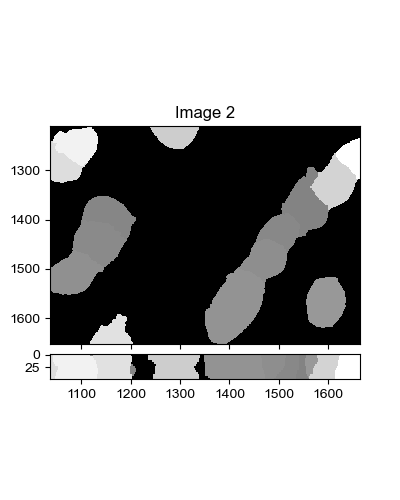

In [13]:
%matplotlib notebook
visual_tools.imshow_mark_3d_v2([_dna_dapi, dna_mask])

<IPython.core.display.Javascript object>


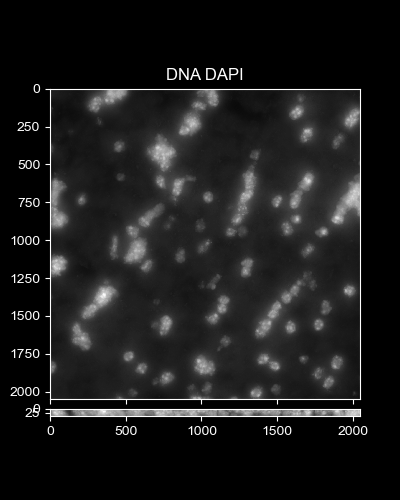

In [15]:
%matplotlib notebook
plt.style.use('dark_background')
_vis = ia.visual_tools.imshow_mark_3d_v2([_dna_dapi, _rna_dapi, _rot_dna_dapi], 
                                         #min_max_default=[10000,50000], 
                                         image_names=['DNA DAPI', 'RNA DAPI', 'Rotated DNA DAPI'])
#_vis.f.savefig(os.path.join(segmentation_folder, 'test_dna_dapi.png'), transparent=True)

## 1.5 batch run translation

In [16]:
%%time
from ImageAnalysis3.segmentation_tools.cell import _batch_align_segmentation
# Multiprocessing
print(f"- Start multiprocessing segmentation alignment", end=' ')
_start_time = time.time()
with mp.Pool(12) as _seg_pool: # 6 cores recommended because of RAM comsumption
    # start multiprocessing
    _seg_pool.starmap(_batch_align_segmentation, _seg_align_args, chunksize=1)
    # close multiprocessing
    _seg_pool.close()
    _seg_pool.join()
    _seg_pool.terminate()
print(f"finish in {time.time()-_start_time:.3f}s. ")

- Start multiprocessing segmentation alignment finish in 2404.419s. 
Wall time: 40min 4s


### 1.5.2 non-parallel version

In [73]:
reload(ia.segmentation_tools.cell)

<module 'ImageAnalysis3.segmentation_tools.cell' from 'E:\\Users\\puzheng\\Documents\\ImageAnalysis3\\segmentation_tools\\cell.py'>

In [ ]:
%matplotlib inline
reload(ia.segmentation_tools.cell)
reload(correction_tools.alignment)
from ImageAnalysis3.segmentation_tools.cell import _batch_align_segmentation
for _args in _seg_align_args:
    _outputs = _batch_align_segmentation(*_args)